# Sentence Transformer

In [1]:
import copy
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk

In [2]:
import re
import string

In [3]:
import textstat
from spellchecker import SpellChecker
0
from lexical_density import lexical_density as Lexical_Density
from TF_IDF import calc_tf_idf
from Add_Periods import Add_Periods
from avg_word_sentence_length import average_word_length, average_sentence_length


## GPU

In [4]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [5]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Utils

In [6]:
def spell_checker_score(text, debug = False):
    def remove_punctuation(st):
        return re.sub(f"[{re.escape(string.punctuation)}]", '', st)
    
    spell = SpellChecker()
    misspelled = spell.unknown(remove_punctuation(text).split())

    if debug:
        for word in misspelled:
            # Get the one `most likely` answer
            print(f"{word} => {spell.correction(word)}")
        
        print(f"misspelled: {len(misspelled)}")
    return len(misspelled)

## Generate dataset and batch

In [7]:
class PromptDataset(Dataset):

    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def deserialize_array(self, binary_string, dtype, shape):
        return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

    def __getitem__(self, index):
        data = self.dataset[index]
        # retrieve values
        student_id = data['student_id']
        prompt_id = data['prompt_id']
        embeddings_question = torch.tensor(self.deserialize_array(data['embeddings_question'], np.float32, (768,))).to(self.device)
        embeddings_text = torch.tensor(self.deserialize_array(data['embeddings_text'], np.float32, (768,))).to(self.device)
        text = torch.tensor(self.deserialize_array(data['text'], np.float32, (768,))).to(self.device)
        content = torch.tensor(data['content']).to(self.device)
        wording = torch.tensor(data['wording']).to(self.device)
        normalized_lexical_density = torch.tensor(data['normalized_lexical_density']).unsqueeze(0).to(self.device)
        normalized_spell_checker = torch.tensor(data['normalized_spell_checker']).unsqueeze(0).to(self.device)
        normalized_tf_idf_question_score = torch.tensor(data['normalized_tf_idf_question_score']).unsqueeze(0).to(self.device)
        normalized_avg_word_length = torch.tensor(data['normalized_avg_word_length']).unsqueeze(0).to(self.device)
        normalized_smog_index = torch.tensor(data['normalized_smog_index']).unsqueeze(0).to(self.device)
        normalized_coleman_liau_index = torch.tensor(data['normalized_coleman_liau_index']).unsqueeze(0).to(self.device)
        normalized_flesch_reading_ease = torch.tensor(data['normalized_flesch_reading_ease']).unsqueeze(0).to(self.device)
        
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'embeddings_question': embeddings_question,
            'embeddings_text': embeddings_text,
            'text': text,
            'content': content,
            'wording': wording,
            'normalized_lexical_density': normalized_lexical_density,
            'normalized_spell_checker': normalized_spell_checker,
            'normalized_tf_idf_question_score': normalized_tf_idf_question_score,
            'normalized_avg_word_length': normalized_avg_word_length,
            'normalized_smog_index': normalized_smog_index,
            'normalized_coleman_liau_index': normalized_coleman_liau_index,
            'normalized_flesch_reading_ease': normalized_flesch_reading_ease,
        }

    def __len__(self) -> int :
        return self.dataset.num_rows

In [8]:
class DataLoaderFactory():

    def __init__(self, path:str = './data/hugging_face', batch_size = 12, device = 'cpu'):
        self.batch_size = batch_size
        self.dataset = load_from_disk(path, keep_in_memory=True)
        self.device = device

        print("1. Loading dataset: ...", end="")
        dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Split datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.2)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = PromptDataset(train_validation_splits['train'], self.device)
        self.val_data = PromptDataset(train_validation_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
    
    
    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        else:
            dataloader = self.dataloader_val

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device

### Load the dataset

In [9]:
dataset = DataLoaderFactory(device=device)
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 5732	-> 477.6666666666667
Validation	: 1433		-> 119.41666666666667
Total		: 7165


7165

### Testing the dataset

In [10]:
batch = dataset.get_batch('train')
nb = next(batch)

In [11]:
print(f"{'student_id:':<25}{len(nb['student_id'])}")
print(f"{'prompt_id:':<25}{len(nb['prompt_id'])}")
print(f"{'embeddings_question:':<25}{nb['embeddings_question'].shape}")
print(f"{'embeddings_text:':<25}{nb['embeddings_text'].shape}")
print(f"{'text:':<25}{nb['text'].shape}")
print(f"{'content:':<25}{nb['content'].shape}")
print(f"{'wording:':<25}{nb['wording'].shape}")
print(f"{'normalized_lexical_density:':<25}{nb['normalized_lexical_density'].shape}")
print(f"{'normalized_spell_checker:':<25}{nb['normalized_spell_checker'].shape}")
print(f"{'normalized_tf_idf_question_score:':<25}{nb['normalized_tf_idf_question_score'].shape}")
print(f"{'normalized_avg_word_length:':<25}{nb['normalized_avg_word_length'].shape}")
print(f"{'normalized_smog_index:':<25}{nb['normalized_smog_index'].shape}")
print(f"{'normalized_coleman_liau_index:':<25}{nb['normalized_coleman_liau_index'].shape}")
print(f"{'normalized_flesch_reading_ease:':<25}{nb['normalized_flesch_reading_ease'].shape}")

student_id:              12
prompt_id:               12
embeddings_question:     torch.Size([12, 768])
embeddings_text:         torch.Size([12, 768])
text:                    torch.Size([12, 768])
content:                 torch.Size([12])
wording:                 torch.Size([12])
normalized_lexical_density:torch.Size([12, 1])
normalized_spell_checker:torch.Size([12, 1])
normalized_tf_idf_question_score:torch.Size([12, 1])
normalized_avg_word_length:torch.Size([12, 1])
normalized_smog_index:   torch.Size([12, 1])
normalized_coleman_liau_index:torch.Size([12, 1])
normalized_flesch_reading_ease:torch.Size([12, 1])


## Kaggle evaluation

### Paths

In [12]:
prompts_train_path = "./data/prompts_train.csv"
prompts_test_path = "./data/prompts_test.csv"

summaries_train_path = "./data/summaries_train.csv"
summaries_test_path = "./data/summaries_test.csv"

model_path = "./out/best_model_script.pt"

submission_path = "./out/submission.csv"

### Loading Model

In [13]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
embeddings_question = ex_batch['embeddings_question']
embeddings_text = ex_batch['embeddings_text']
embeddings_answer = ex_batch['text']

content = ex_batch['content']
wording = ex_batch['wording']

normalized_lexical_density = ex_batch['normalized_lexical_density']
normalized_spell_checker = ex_batch['normalized_spell_checker']
normalized_tf_idf_question_score = ex_batch['normalized_tf_idf_question_score']
normalized_avg_word_length = ex_batch['normalized_avg_word_length']
normalized_smog_index = ex_batch['normalized_smog_index']
normalized_coleman_liau_index = ex_batch['normalized_coleman_liau_index']
normalized_flesch_reading_ease = ex_batch['normalized_flesch_reading_ease']

example_input_tensor = torch.cat(
    (
        embeddings_text,
        embeddings_question,
        embeddings_answer
    ), dim=1)
features = (normalized_lexical_density.to(device), \
            normalized_spell_checker.to(device), \
            normalized_tf_idf_question_score.to(device), \
            normalized_avg_word_length.to(device), \
            normalized_smog_index.to(device), \
            normalized_coleman_liau_index.to(device), \
            normalized_flesch_reading_ease.to(device) \
           )

In [14]:
print(embeddings_answer.shape)
for x in features:
    print(x.shape)

torch.Size([12, 768])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])


In [15]:
loaded_model = torch.jit.load(model_path).to(device)
loaded_model.eval()

RecursiveScriptModule(
  original_name=QA_Score_Model
  (fc_text_question_answer): RecursiveScriptModule(original_name=Linear)
  (fc_lexical): RecursiveScriptModule(original_name=Linear)
  (fc_spell): RecursiveScriptModule(original_name=Linear)
  (fc_tfidf): RecursiveScriptModule(original_name=Linear)
  (fc_avg_word_length): RecursiveScriptModule(original_name=Linear)
  (fc_smog): RecursiveScriptModule(original_name=Linear)
  (fc_coleman): RecursiveScriptModule(original_name=Linear)
  (fc_flesch): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (out_content): RecursiveScriptModule(original_name=Linear)
  (out_wording): RecursiveScriptModule(original_name=Linear)
)

In [16]:
# loaded_model(example_input_tensor.to(device))

In [17]:
# tensor1, tensor2 = loaded_model(example_input_tensor.to(device)), torch.stack((content, wording), dim=1)
tensor1, tensor2 = loaded_model(example_input_tensor.to('cpu'), features), torch.stack((content, wording), dim=1)

for (col1_tensor1, col2_tensor1), (col1_tensor2, col2_tensor2) in zip(tensor1, tensor2):
    print(f"[{col1_tensor1:>6.3f} => {col1_tensor2:>6.3f} = {col1_tensor2-col1_tensor1:>6.3f}] \t | \t [{col2_tensor1:>6.3f} => {col2_tensor2:>6.3f} = {col2_tensor2 - col2_tensor1:>6.3f}]")

[-0.196 => -0.249 = -0.053] 	 | 	 [-0.497 =>  0.383 =  0.880]
[-0.589 => -0.457 =  0.132] 	 | 	 [ 0.015 => -0.043 = -0.058]
[ 0.318 =>  0.376 =  0.058] 	 | 	 [ 0.166 =>  0.464 =  0.297]
[ 0.415 =>  1.076 =  0.662] 	 | 	 [-0.062 =>  0.074 =  0.136]
[-0.678 => -0.564 =  0.114] 	 | 	 [-0.740 =>  0.544 =  1.284]
[-0.209 => -0.393 = -0.184] 	 | 	 [-0.129 =>  0.627 =  0.756]
[ 0.842 =>  1.268 =  0.426] 	 | 	 [ 0.392 =>  0.579 =  0.187]
[ 1.542 =>  1.782 =  0.240] 	 | 	 [ 1.032 =>  0.912 = -0.120]
[-0.936 => -1.264 = -0.328] 	 | 	 [-0.899 => -1.505 = -0.606]
[-0.993 => -0.794 =  0.199] 	 | 	 [-1.179 => -1.545 = -0.366]
[-0.517 => -0.564 = -0.046] 	 | 	 [-0.789 => -1.127 = -0.338]
[-0.323 => -0.993 = -0.671] 	 | 	 [ 0.336 => -0.367 = -0.703]


### Load SentenceTransformer model

In [18]:
sentence_transformer_model = SentenceTransformer('all-mpnet-base-v2')

### Loading files

In [19]:
prompts_train = pd.read_csv(prompts_train_path)
prompts_test = pd.read_csv(prompts_test_path)

In [20]:
summaries_train = pd.read_csv(summaries_train_path)
summaries_test = pd.read_csv(summaries_test_path)

In [21]:
if len(prompts_test) == 2:
    prompts_test = prompts_train.copy()
    summaries_test = summaries_train.copy()

### Visualize datasets

In [22]:
prompts_test

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [23]:
summaries_test.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Inference

### Normilized function
usefull to normalize between -1 and 1 content and wording

In [24]:
def normalize_value(x, min=-2, max=4):
    return 2*((x-min)/(max-min))-1

inverse normalization

In [25]:
# def rescale(value, old_min=-1, old_max=1, new_min=-2, new_max=4):
#     return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

### Helpers

In [26]:
def to_numpy(var):
    if isinstance(var, torch.Tensor):
        return var.cpu().numpy()
    return var

### Preprocess_prompts
We do this separatly in order to preprocess only on time each row

In [27]:
def preprocess_prompts(prompts_df: pd.DataFrame) -> pd.DataFrame:
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'prompt_id': [],
        'embeddings_question': [],
        # 'prompt_title': [],
        'embeddings_text': [],
        'tf_idf': []
    })

    for index, row in prompts_df.iterrows():
        # retrieve columns
        prompt_id = row['prompt_id']
        prompt_question = row['prompt_question']
        # prompt_title = row['prompt_title'] # we do not need the title
        prompt_text = row['prompt_text']

        tf_idf = calc_tf_idf(prompt_question, prompt_text, 10)

        # we are creating a batch of the sentences we want to get embeddings
        sentences = [prompt_question, prompt_text]

        # calling model embedding
        embeddings = sentence_transformer_model.encode(sentences)

        # Create a new row
        new_row = pd.DataFrame({
            'prompt_id': [prompt_id],
            'embeddings_question': [embeddings[0]],
            'embeddings_text': [embeddings[1]],
            'tf_idf': [tf_idf],
            'prompt_question': [prompt_question],
            'prompt_text': [prompt_text]
        })
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    return new_data

### Preprocess one row to create the input

In [28]:
def preprocess(row, prompts_df: pd.DataFrame):
    # retrieve columns from summaries_df
    prompt_id = row["prompt_id"]
    text = row["text"]

    # Data engineering
    # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
    text = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', text)
    text = Add_Periods(text)
    
    # FK_grade, Gunning_Fog, SMOG = readability_scores(text)
    smog_index = getattr(textstat, 'smog_index')(text)
    coleman_liau_index = getattr(textstat, 'coleman_liau_index')(text)
    flesch_reading_ease = getattr(textstat, 'flesch_reading_ease')(text)
    
    lexical_density = Lexical_Density(text)
    spell_checker = spell_checker_score(text)
    
    avg_word_length = average_word_length(text)

    # we are creating a batch of the sentences we want to get embeddings
    sentences = [row["text"]]

    # calling model embedding
    embeddings = sentence_transformer_model.encode(sentences)
    embeddings_answer = torch.tensor(embeddings[0])
    
    # retrieve usefull columns from preprocessed prompt
    prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
    embeddings_question, embeddings_text = torch.tensor(prompt_row['embeddings_question'].item()), torch.tensor(prompt_row['embeddings_text'].item())
    
    # Calculating tf_idf for prompt question and prompt text in relation with answere text word present in the text
    tf_idf = [word.lower() for word in prompt_row['tf_idf'].item()]
    tf_idf_question = [word.lower() for word in calc_tf_idf(prompt_row["prompt_question"].item(), text, 10)]
    
    # Calculate the score representing the number of words from prompt_tf_idf present in answer_tf_idf
    tf_idf_question_score = sum(word in tf_idf_question for word in tf_idf)

    features = (
        torch.tensor([[normalize_value(lexical_density, min=0, max=1)]]).to(device), \
        torch.tensor([[normalize_value(spell_checker, min=0, max=10)]]).to(device), \
        torch.tensor([[normalize_value(tf_idf_question_score, min=0, max=10)]]).to(device), \
        torch.tensor([[normalize_value(avg_word_length, min=3, max=10)]]).to(device), \
        torch.tensor([[normalize_value(smog_index, min=0, max=17)]]).to(device), \
        torch.tensor([[normalize_value(coleman_liau_index, min=0, max=17)]]).to(device), \
        torch.tensor([[normalize_value(flesch_reading_ease, min=1, max=100)]]).to(device) \
       )
    # Create input
    input = torch.cat(
        (
            embeddings_text,
            embeddings_question,
            embeddings_answer
        ), dim=0).unsqueeze(0).to(device)

    return input, \
        features



### Inference

In [29]:
def inference(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame):
    new_data = pd.DataFrame({
        'student_id': [],
        'content': [],
        # 'prompt_title': [],
        'wording': []
    })

    # preprocess prompt
    prompts_df = preprocess_prompts(prompts_df)
    # Iterate over summaries
    for index, row in summaries_df.iterrows():
        print(f"\r{index+1}/{len(summaries_df)}", end="")
        student_id = row['student_id']
        
        input, \
        features = preprocess(row, prompts_df)

        outputs = loaded_model(input, features)
        content, wording = outputs[0].detach().cpu().numpy()

        new_row = pd.DataFrame({'student_id': [student_id], 'content': [content], 'wording': [wording]})

        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)
    new_data.to_csv(submission_path, index=False)

In [30]:
inference(summaries_test, prompts_test)

3/7165

/var/folders/jl/xfg9q6k157b20f4pm0vhxk5c0000gn/T/ipykernel_28553/3762933422.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)


7165/7165

## checking hist

In [31]:
import matplotlib.pyplot as plt

In [32]:
xmin, xmax = -2, 4
ymin, ymax = 0, 2000

In [33]:
submission_file = pd.read_csv(submission_path)
submission_file

,student_id,content,wording
0,000e8c3c7ddb,0.051113,0.709849
1,0020ae56ffbf,-0.892727,-0.847612
2,004e978e639e,1.597126,1.156975
3,005ab0199905,-0.763913,-0.692339
4,0070c9e7af47,2.361634,1.806781
...,...,...,...
7160,ff7c7e70df07,0.195567,-0.086520
7161,ffc34d056498,-0.522242,-0.565264
7162,ffd1576d2e1b,-0.504044,-0.596660
7163,ffe4a98093b2,-0.054663,0.046478


In [34]:
df1 = summaries_test[["student_id", "content", "wording"]] # Real
df2 = submission_file # pred
# Setting 'student_id' as index
df1.set_index('student_id', inplace=True)
df2.set_index('student_id', inplace=True)

In [35]:
# Subtracting corresponding 'content' and 'wording' columns and creating a new DataFrame
df3 = pd.DataFrame()
df3['content'] = df1['content'] - df2['content']
df3['wording'] = df1['wording'] - df2['wording']
df3.reset_index(inplace=True)

print(df3)

        student_id   content   wording
0     000e8c3c7ddb  0.154569 -0.329312
1     0020ae56ffbf  0.344423  1.354368
2     004e978e639e  1.531802  3.074250
3     005ab0199905  0.553299  0.220924
4     0070c9e7af47  0.911260  1.412976
...            ...       ...       ...
7160  ff7c7e70df07  0.010115  0.467058
7161  ffc34d056498  0.213794  0.613435
7162  ffd1576d2e1b -0.904136  0.103056
7163  ffe4a98093b2 -0.338647  0.580650
7164  fffbccfd8a08  0.591328 -0.244945

[7165 rows x 3 columns]


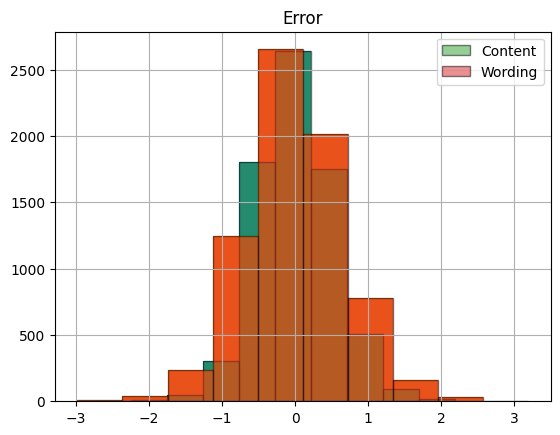

In [36]:
df3['content'].hist(), df3['wording'].hist()

df3['content'].hist(label='Content', alpha=0.5, edgecolor='k')
df3['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
# Adding a legend
plt.legend()
plt.title('Error')
plt.show()

In [37]:
# Calculate the average of 'content' and 'wording' columns
avg_content = df3['content'].mean()
avg_wording = df3['wording'].mean()

print(f"Average Content: {avg_content}")
print(f"Average Wording: {avg_wording}")


Average Content: 0.004142085412080056
Average Wording: 0.0003382869057126047


In [38]:
# Calculate the overall average of 'content' and 'wording' columns
avg_overall = df3[['content', 'wording']].mean().mean()
print(f"Overall Average: {avg_overall}")


Overall Average: 0.0022401861588963305


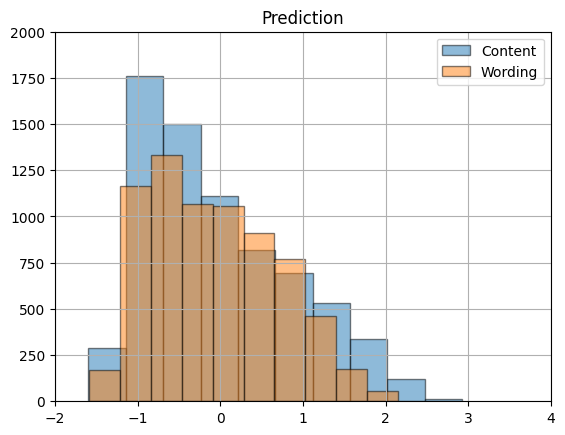

In [39]:
submission_file = pd.read_csv(submission_path)

submission_file['content'].hist(label='Content', alpha=0.5, edgecolor='k')
submission_file['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
plt.xlim([xmin, xmax])  # Set x-axis limits
plt.ylim([ymin, ymax])  # Set y-axis limits
# Adding a legend
plt.legend()
plt.title('Prediction')
plt.show()

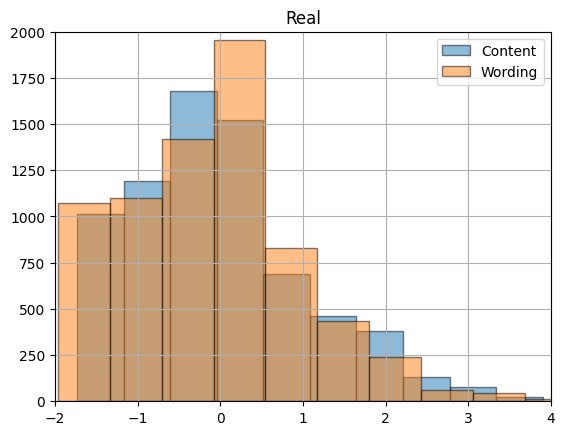

In [40]:
summaries_test['content'].hist(label='Content', alpha=0.5, edgecolor='k')
summaries_test['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
plt.xlim([xmin, xmax])  # Set x-axis limits
plt.ylim([ymin, ymax])  # Set y-axis limits
# Adding a legend
plt.legend()
plt.title('Real')
plt.show()